In [187]:
import scipy
import h5py
import numpy as np
from pymatreader import read_mat
import mne
import tensorflow as tf
import pickle
import lzma
import blosc
import sys
import eelbrain as eel
from scipy.io import wavfile
import librosa    
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [188]:
X = np.load('X.npy')

In [189]:
y = np.load('y.npy')

In [190]:
att = np.load('attended.npy')

In [191]:
mas = np.load('masker.npy')

In [192]:
lab = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2','AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2','FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4','P6','P8','P10','PO8','PO4','O2','EXG1','EXG2']

In [193]:
datapoints = 20

In [194]:
def resample_envelope(filename):
    wav = eel.load.wav(filename)
    data = eel.filter_data(wav, 10e3, 15e3)
    data = eel.resample(data.envelope(),128)
    
    return data

In [195]:
id = 0
n = 3

In [ ]:
eeg = X[datapoints*id:datapoints*(id+n),:,5*128:38*128]
attended = list(map(resample_envelope,att[datapoints*id:datapoints*(id+n)]))
masker = list(map(resample_envelope,mas[datapoints*id:datapoints*(id+n)]))

Setting up band-pass filter from 1e+04 - 1.5e+04 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10000.00
- Lower transition bandwidth: 2500.00 Hz (-6 dB cutoff frequency: 8750.00 Hz)
- Upper passband edge: 15000.00 Hz
- Upper transition bandwidth: 3750.00 Hz (-6 dB cutoff frequency: 16875.00 Hz)
- Filter length: 59 samples (0.001 s)

Setting up band-pass filter from 1e+04 - 1.5e+04 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10000.00
- Lower transition bandwidth: 2500.00 Hz (-6 dB cutoff frequency: 8750.00 Hz)
- Upper passband edge: 15000.00 Hz
- Upper transition bandwidth: 

In [ ]:
attended = np.asarray(attended,dtype = np.float64)
masker = np.asarray(masker,dtype = np.float64)

In [ ]:
print(attended.dtype)
print(masker.dtype)
print(eeg.dtype)

In [ ]:
plt.plot(masker[0])

In [ ]:
def normeeg(eeg):
    data = []
    for x in eeg:
        d = (x-np.mean(x))/np.std(x)
        data.append(d)
    return data

In [ ]:
plt.plot(normeeg(eeg[0]))

In [ ]:
def create_NDVar(eeg,attended,masker):
    #eeg = normalize(eeg)
    #eeg = np.asarray(eeg)
    eeg = np.asarray(normeeg(eeg))
    attended = (attended-np.mean(attended))/np.std(attended)
    tstep = 1. / 128
    n_times = eeg.shape[-1]
    time = eel.UTS(0, tstep, n_times)
    sensor = eel.Sensor.from_montage('mgh70')[:66]
    attended = eel.NDVar(attended, (time,), name='attended')
    EEG= eel.NDVar(eeg, (sensor,time), name='EEG', info={'unit': 'µV'})
    masker = eel.NDVar(masker, (time,), name='masker')
    return EEG,attended,masker

In [166]:
EEG = [create_NDVar(eeg[i],attended[i],masker[i])[0] for i in range(0,10)]
att = [create_NDVar(eeg[i],attended[i],masker[i])[1] for i in range(0,10)]

In [176]:
att = eel.combine(att)
EEG = eel.combine(EEG)
trf = eel.boosting(att,EEG,-0.5,0.1,scale_data=False)
trf.residual

22759.3759661003

In [177]:
env = convolve(trf.h,EEG[0])

In [178]:
EEG[9]

<NDVar 'EEG': 66 sensor, 4224 time>

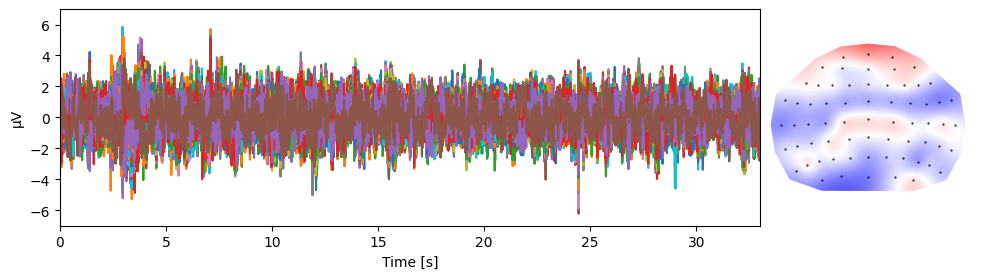

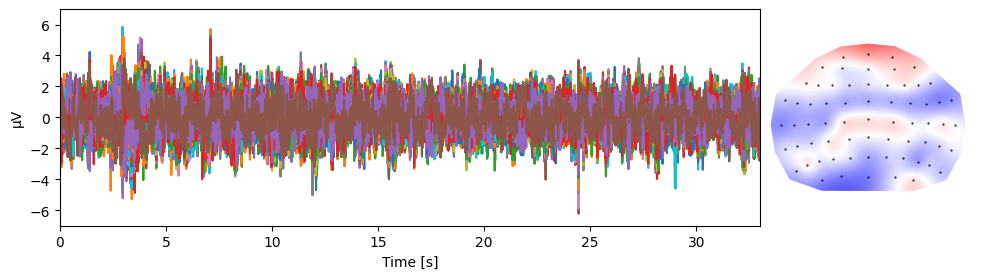

In [179]:
eel.plot.TopoButterfly(EEG[9])

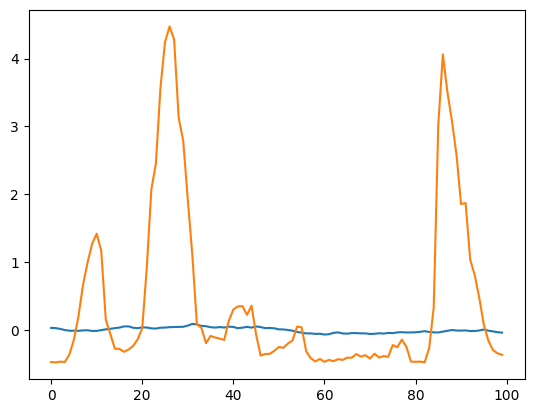

In [180]:
plt.plot(env.x[0:100])
plt.plot(att[0].x[0:100])

In [181]:
def predict(trf,eeg,attended,masker):
    eeg,attended,masker = create_NDVar(eeg,attended,masker)
    pred = convolve(trf.h_scaled,eeg)
    #pred = np.abs(pred)
    peara = scipy.stats.pearsonr(pred,attended)
    pearm = scipy.stats.pearsonr(pred,masker)
    if peara.statistic>pearm.statistic:
        print(peara.statistic)
        return 1
    else:
        return 0

In [182]:
trf.residual

22759.3759661003

In [185]:
total = 0
for i in range(0,20):
    total+=predict(trf,eeg[i],attended[i],masker[i])

0.1023160766756741
0.08719315427892363
0.07403508381283536
0.031148952552906294
0.07899482829848684
0.045146040775442924
0.052872570738530356
0.031554964772409405
-0.0041398419084905345
-0.01406813068836078
-0.0002149889704326155
0.05007131481129573
0.07802041208493334


In [186]:
total

13

In [120]:
def plot(trf,eeg,attended,masker,start = 5 ,stop = 400):
    eeg,attended,masker = create_NDVar(eeg,attended,masker,start,size=384)
    pred = convolve(trf,eeg).x

    plt.plot(np.abs(pred)[0:200],'b')
    plt.plot(attended.x[0:200],'r')
    #plt.plot(masker.x)
    return None

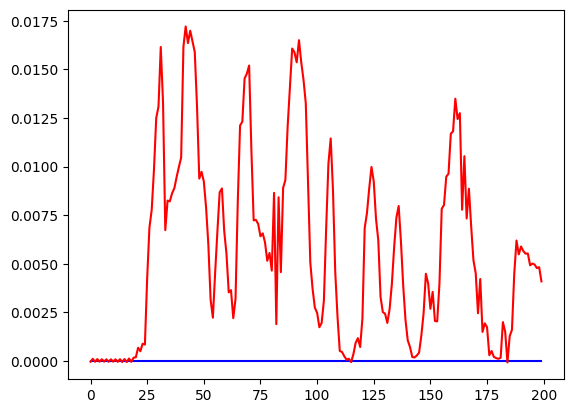

In [23]:
plot(k,eeg[19],attended[19],masker[19])

In [142]:
total

9

In [306]:
scipy.stats.pearsonr(data[0],k)

PearsonRResult(statistic=-0.024667635656146932, pvalue=0.10893996286994899)

In [4]:
masker = mas['j']

In [6]:
masker = np.asarray(masker)
masker = masker.reshape(-1)


In [9]:
masker = list(map(lambda x: x[0:28] + "\\Files_Audio\\" + x[28:],masker))

In [10]:
masker

['C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_10_Borgmestrene_Det_er_dr_nhamrende _ Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_14_S_rlig_indsats_til_ledige_over_50_r_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_13_Boligpolitisk_proces_skudt_i_gang_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_35_Mere_gang_i_den_p_Torvet_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_17_Stoholm_politiker_afl_ser_i_folketinget_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_16_Ny_gadeplansmedarbejder_skal_f_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_17_Br_ndby_Kommune_er_tavs_i_ridecentersag_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_08_Vi_har_ikke_parallelsamfund_i_Kolding_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_14_Kolding_s_tter_turbo_p_at_tiltr_kke_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_29_Fitness_s

In [11]:
np.save('masker.npy',masker)

In [ ]:
[9:35 AM] Emina Alickovic (EALI)
    datas = []
fs = 100
for isubj, subject in tqdm(enumerate(subjects[2:3])):
    preprocessed_path = data_root / 'results' / 'cortical2' / 'preprocessed'
    subjectnum = isubj #'sub-0005'
    #subject    = subjects[subjectnum]
    print(subject)
    data = eel.load.unpickle(preprocessed_path / f'{​​subject}​​_ses-{​​session}​​_eeg_env_trials_5s_ica_applied.pkl')
    print(preprocessed_path / f'{​​subject}​​_ses-{​​session}​​_eeg_env_trials_5s_ica_applied.pkl')
    data['f0_fg_preds'] = []
    data['f0_fg_eegs'] = []
    data['f0_bg_preds'] = []
    data['f0_bg_eegs'] = []
    res_path = data_root / 'results' / 'cortical2' / 'preprocessed'/ 'TRF_f0'
    res_path.mkdir(exist_ok=True, parents=True)
    trial_info = eel.load.tsv(data_root / 'Data_Behavioural' / subject / f'{​​subject}​​_trial_info.csv', encoding="latin1")
    tstart = time.perf_counter()
    for session in [3]: #[3,4,5]:
        if subject=='sub-0004' and session==3: # error no trigger data in bdf file
            continue
        if subject=='sub-0004' and session==5: # session splitted into 2 bdf files, deal with later (1st bdf file has 17 trials)
            continue
        trial_ds = trial_info.sub(f'session_nr=={​​session}​​')
        f0_fg_preds = []
        f0_fg_eegs = []
        f0_bg_preds = []
        f0_bg_eegs = []
        for i in range(33):
            stimfolder = data_root_f0
            mat = scipy.io.loadmat(stimfolder / f"{​​trial_ds['target_filename'][i][:-4]}​​_f0.mat")
            f0vals = [mat['f0'][i,0] for i in range(mat['f0'].shape[0]) if mat['t'][i,0]>=1 or mat['t'][i,0]<=59]
            tvals  = [mat['t'][i,0]  for i in range(mat['t'].shape[0])  if mat['t'][i,0]>=1 or mat['t'][i,0]<=59]
            f0pred = eel.event_impulse_predictor(data['eeg'].time, time=tvals, value=f0vals)
            idxsfg   = np.where(np.asarray(f0pred.x)>50)[0]
            eegfg    = data['eeg'][i,:,:].copy()
            eegfg    = eel.NDVar(eegfg.x[:,idxsfg], (eegfg.sensor, eel.UTS(0, 1/fs, len(idxsfg))))
            f0predfg = f0pred.copy()
            f0predfg = eel.NDVar(f0predfg.x[idxsfg], eel.UTS(0, 1/fs, len(idxsfg)))
            print(f0predfg.shape)
            print(eegfg.shape)
            f0_fg_preds.append(f0predfg)
            f0_fg_eegs.append(eegfg)
            # eel.plot.UTS([[100e5*eeg2.sub(sensor='Cz').sub(time=(5, 7)), f0pred2.sub(time=(5, 7))]]);
            mat = scipy.io.loadmat(stimfolder / f"{​​trial_ds['masker_filename'][i][:-4]}​​_f0.mat")
            f0vals = [mat['f0'][i,0] for i in range(mat['f0'].shape[0]) if mat['t'][i,0]>=1 or mat['t'][i,0]<=59]
            tvals  = [mat['t'][i,0]  for i in range(mat['t'].shape[0])  if mat['t'][i,0]>=1 or mat['t'][i,0]<=59]
            f0pred = eel.event_impulse_predictor(data['eeg'].time, time=tvals, value=f0vals)
            idxsbg   = np.where(np.asarray(f0pred.x)>50)[0]
            eegbg    = data['eeg'][i,:,:].copy()
            print('masker')
            print(eegbg)
            eegbg    = eel.NDVar(eegbg.x[:,idxsbg], (eegbg.sensor, eel.UTS(0, 1/fs, len(idxsbg))))
            f0predbg = f0pred.copy()
            f0predbg = eel.NDVar(f0predbg.x[idxsbg], eel.UTS(0, 1/fs, len(idxsbg)))
            print(f0predbg.shape)
            print(eegbg.shape)
            f0_bg_preds.append(f0predbg)
            f0_bg_eegs.append(eegbg)
        f0_fg_preds = eel.combine(f0_fg_preds, dim_intersection=True)
        f0_fg_eegs  = eel.combine(f0_fg_eegs,  dim_intersection=True)
        f0_bg_preds = eel.combine(f0_bg_preds, dim_intersection=True)
        f0_bg_eegs  = eel.combine(f0_bg_eegs,  dim_intersection=True)
        print(f0_fg_preds)
        print(f0_fg_eegs)
        data['f0_fg_preds'].append(f0_fg_preds)
        data['f0_fg_eegs'].append(f0_fg_eegs)
        data['f0_bg_preds'].append(f0_bg_preds)
        data['f0_bg_eegs'].append(f0_bg_eegs)

        datas.append(data)


In [ ]:
fs = 1/eegnd.time.tstep
 
            eegs = []
            fgenvs = []
            bgenvs = []
 
            for i in range(len(idx_starts)):
                eeg = eegnd.sub(time=(idx_starts[i]+5, idx_starts[i]+65))
                eeg = eel.NDVar(eeg.x, (eeg.sensor, eel.UTS(0, eeg.time.tstep, eeg.x.shape[1])))
                print(i, eeg.time.tmax, len(eeg), ' '*20)
 
                stimfolder = data_root / r'Files_PsychToolbox\Psychtoolbox\AudioFiles_SameRMSValue'
                fg = eel.load.wav(stimfolder / trial_ds['target_filename'][i])
                bg = eel.load.wav(stimfolder / trial_ds['masker_filename'][i])
                #fg = eel.load.wav(data_root / 'Files_PsychToolbox / Psychtoolbox / AudioFiles_SameRMSValue' / trial_ds['target_filename'][i])
                #bg = eel.load.wav(data_root / 'Files_PsychToolbox / Psychtoolbox / AudioFiles_SameRMSValue' / trial_ds['masker_filename'][i])
                fgenv = eel.resample(eel.filter_data(fg.envelope(), lc, hc), fsds)
                bgenv = eel.resample(eel.filter_data(bg.envelope(), lc, hc), fsds)
 
                eegs.append(eeg.sub(time=(0, 59)))
                fgenvs.append(fgenv.sub(time=(0, 59)))
                bgenvs.append(bgenv.sub(time=(0, 59)))
 
            eegs = eel.combine(eegs)
            fgenvs = eel.combine(fgenvs)
            bgenvs = eel.combine(bgenvs)
            eegdict = dict(eegs=eegs, fgenvs=fgenvs, bgenvs=bgenvs)